# Six Priors

# Approach
1. Clear out and remove irrelevant points(far away, clustering of points that are very close(<0.5m))
2. Divide the points into prior regions
3. For each region, apply convex hull, concave hull, delauney triangles - http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
4. Add limit points for each prior, to ensure we get boundary on one side and the priors rectangle on the other side
5. {TBD} Custom algorithm to detect points facing the car- connect car(0,0) to each point. If the line connecting the point and the car intersects any of the lines of the delauney traingles, remove that point. The points that remain should be the boundary points.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pylab as pl
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import math
from shapely.ops import cascaded_union, polygonize
import shapely.geometry as geometry
# from matplotlib import animation, rc
# from IPython.display import HTML
from IPython import display
pl.ion()

In [2]:
csvs = sorted(glob.glob("./*.csv"))

355


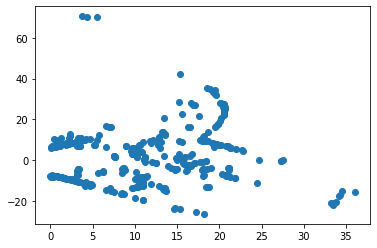

In [5]:
df = pd.read_csv("../2011_09_26_drive_0005_sync_vscan/frame_79.csv")
print(len(df))
pl.scatter(df.x,df.y)

In [6]:
X = df.to_numpy()[:,:2]
db = DBSCAN(eps=0.5, min_samples=2).fit(X)

Estimated number of clusters: 69
Estimated number of noise points: 79


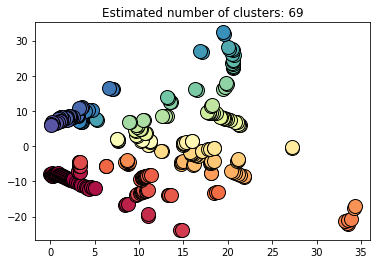

In [7]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [8]:
df.to_numpy()[:,:2].shape

(355, 2)

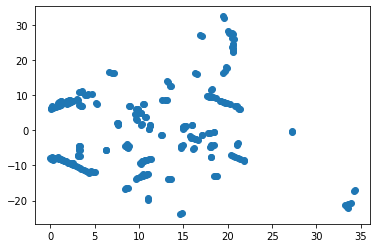

In [9]:
pl.scatter(X[db.core_sample_indices_][:,0],X[db.core_sample_indices_][:,1])

In [10]:
filtered_X = X[db.core_sample_indices_]

In [11]:
# using 2 priors for now (y>0 and y<0)
# prior1 = df[df.y>0].to_numpy()[:,:2]
# prior2 = df[df.y<=0].to_numpy()[:,:2]
prior1_y = filtered_X[filtered_X[:,1]>0,:]
prior2_y = filtered_X[filtered_X[:,1]<=0,:]


"""
Priors 

0    X1    X2     W      
-------------------
|    |     |      |
| 1  |  2  |  3   |
|    |     |      |
0]>--+-----+------+
|    |     |      |
| 4  |  5  |  6   |
|    |     |      |
-------------------

"""
# split priors by X values
xlim1 = 5
xlim2 = 15
print("Length of upper half:",len(prior1_y))
prior1 = prior1_y[prior1_y[:,0]<xlim1,:]
prior2 = prior1_y[np.logical_and(prior1_y[:,0]>=xlim1,prior1_y[:,0]<xlim2),:]
prior3 = prior1_y[prior1_y[:,0]>=xlim2,:]
print("Length of upper priors:",prior1.shape,prior2.shape,prior3.shape)

print("Length of lower half:",len(prior2_y))
prior4 = prior2_y[prior2_y[:,0]<xlim1,:]
prior5 = prior2_y[np.logical_and(prior2_y[:,0]>=xlim1,prior2_y[:,0]<xlim2),:]
prior6 = prior2_y[prior2_y[:,0]>=xlim2,:]
print("Length of lower priors:",prior4.shape,prior5.shape,prior6.shape)


Length of upper half: 129
Length of upper priors: (38, 2) (43, 2) (48, 2)
Length of lower half: 147
Length of lower priors: (52, 2) (51, 2) (44, 2)


In [12]:
# # add points to prior
# 0,maxY and maxX,maxY to prior1
# 0, minY and maxX,minY to prior2

maxX = np.max(filtered_X[:,0])
maxY = np.max(filtered_X[:,1])
minY = np.min(filtered_X[:,1])
# print(prior1.shape, prior2.shape)
# print(maxX,maxY,minY)
prior1 = np.vstack([prior1,np.array([[0,maxY],[xlim1,maxY]])])
prior2 = np.vstack([prior2,np.array([[xlim1,maxY],[xlim2,maxY]])])
prior3 = np.vstack([prior3,np.array([[xlim2,maxY],[maxX,maxY]])])

prior4 = np.vstack([prior4,np.array([[0,minY],[xlim1,minY]])])
prior5 = np.vstack([prior5,np.array([[xlim1,minY],[xlim2,minY]])])
prior6 = np.vstack([prior6,np.array([[xlim2,minY],[maxX,minY]])])
# print(prior1.shape, prior2.shape)

# Upper Half

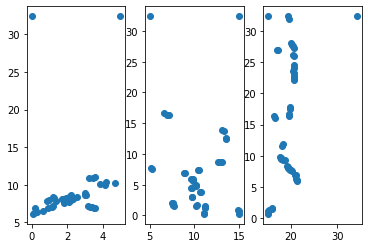

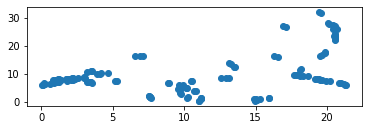

In [13]:
pl.subplot(131)
pl.scatter(prior1[:,0],prior1[:,1])
pl.subplot(132)
pl.scatter(prior2[:,0],prior2[:,1])
pl.subplot(133)
pl.scatter(prior3[:,0],prior3[:,1])
pl.show()
pl.subplot(212)
pl.scatter(prior1_y[:,0],prior1_y[:,1])

# Lower Half

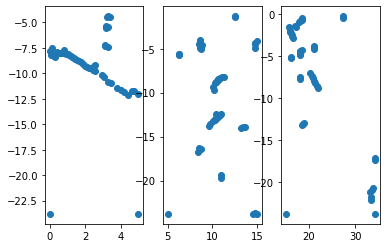

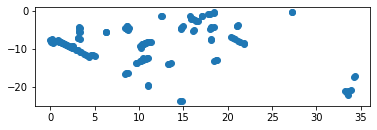

In [14]:
# pl.scatter(prior2[:,0],prior2[:,1])
pl.subplot(131)
pl.scatter(prior4[:,0],prior4[:,1])
pl.subplot(132)
pl.scatter(prior5[:,0],prior5[:,1])
pl.subplot(133)
pl.scatter(prior6[:,0],prior6[:,1])
pl.show()
pl.subplot(212)
pl.scatter(prior2_y[:,0],prior2_y[:,1])

In [15]:
def getBoundary(points):
    added_vertices = [points.shape[0]-1,points.shape[0]-2]
    if(len(points)<3):
        return None, []
    hull = ConvexHull(points)
    vs = list(hull.vertices)
    for v in added_vertices:
        if v in vs:
            vs.remove(v)
    boundary = points[vs]
    return hull, boundary
 

In [16]:
priors = [prior1,prior2,prior3,prior4,prior5,prior6]
hulls = []
boundaries = []
for prior in priors:
    hull, boundary = getBoundary(prior)
    hulls.append(hull)
    boundaries.append(boundary)

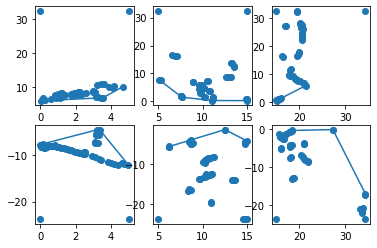

In [17]:
# Plot hulls
# pl.subplot(131)
# convex_hull_plot_2d(hulls[0],pl.ax)
# pl.subplot(132)
# convex_hull_plot_2d(hulls[1],pl.ax)
# pl.subplot(133)
# convex_hull_plot_2d(hulls[2],pl.ax)

for i in range(231,237):
    pl.subplot(i)
    pl.scatter(priors[i-231][:,0],priors[i-231][:,1])
    pl.plot(boundaries[i-231][:,0],boundaries[i-231][:,1])
# pl.show()

In [18]:
priors[2]

array([[15.0831  ,  0.658541],
       [15.0382  ,  1.05157 ],
       [15.31    ,  1.20492 ],
       [15.9254  ,  1.39329 ],
       [15.9506  ,  1.53587 ],
       [21.3585  ,  5.92323 ],
       [21.246   ,  6.09218 ],
       [21.1877  ,  6.27607 ],
       [20.9868  ,  6.81904 ],
       [20.8213  ,  6.96671 ],
       [20.2126  ,  7.55717 ],
       [19.9096  ,  7.64259 ],
       [19.6822  ,  7.75302 ],
       [19.5263  ,  7.88912 ],
       [19.4228  ,  8.04517 ],
       [19.2735  ,  8.1811  ],
       [19.1589  ,  8.33051 ],
       [18.6429  ,  9.295   ],
       [18.298   ,  9.32331 ],
       [18.1439  ,  9.44511 ],
       [17.9336  ,  9.53544 ],
       [17.8654  ,  9.70013 ],
       [17.6932  ,  9.80751 ],
       [18.0974  , 11.5293  ],
       [18.1897  , 11.8125  ],
       [19.4865  , 16.3512  ],
       [19.6331  , 16.7682  ],
       [19.8672  , 17.577   ],
       [19.8498  , 17.8728  ],
       [16.5775  , 16.0087  ],
       [16.3051  , 16.3051  ],
       [20.6029  , 22.0939  ],
       [

In [19]:
boundaries[0]

array([[ 0.0536479,  6.14744  ],
       [ 3.54429  ,  6.95607  ],
       [ 4.68031  , 10.27     ]])